In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
from itertools import product

from sales_forecasting.utils import build_submission_df
from sales_forecasting.plot import plot_timeseries
from sales_forecasting.features import col_name

In [4]:
df_unfiltered = pd.read_parquet(".data/data.parquet")

In [5]:
# Filter redundant columns
cols = ['date_block_num', 'shop_id', 'city_id', 'item_id', 'item_category_id', 'general_item_category_id', 'item_price', 'date_month', 'item_cnt_day']
df = df_unfiltered[cols]

In [6]:
# Filter outliers
shp = df.shape[0]
outliers_item_price_index = df['item_price'] > 100000
outliers_item_cnt_day_index = df['item_cnt_day'] > 1000

display(df[outliers_item_price_index])
display(df[outliers_item_cnt_day_index])

df = df.drop(df[outliers_item_price_index].index)
df = df.drop(df[outliers_item_cnt_day_index].index)
print(f"Filtered {shp - df.shape[0]} outliers")

,date_block_num,shop_id,city_id,item_id,item_category_id,general_item_category_id,item_price,date_month,item_cnt_day
325725,11,12,8,6066,75,15,307980.0,11,1.0


,date_block_num,shop_id,city_id,item_id,item_category_id,general_item_category_id,item_price,date_month,item_cnt_day
334422,33,12,8,11373,9,3,0.908714,9,2169.0


/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_78300/4117026004.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.drop(df[outliers_item_cnt_day_index].index)


Filtered 2 outliers


In [7]:
# Imput missing/wrong values
missing_item_price_index = df['item_price'] <= 0
mean_imputation = df[(df.shop_id == 32) & (df.item_id == 2973) & (df.date_block_num == 4) & (df.item_price > 0)]['item_price'].mean()
df.loc[missing_item_price_index, 'item_price'] = mean_imputation
display(df[missing_item_price_index])

,date_block_num,shop_id,city_id,item_id,item_category_id,general_item_category_id,item_price,date_month,item_cnt_day
1645106,4,32,14,2973,19,5,1874.0,4,1.0


In [8]:
# Filter repeating shops
repeating_shops_pairs =  [(0, 57), (1, 58), (10, 11)]

for orig, rep in repeating_shops_pairs:
    display(df_unfiltered[df_unfiltered.shop_id.isin([rep, orig])][['shop_id', 'shop_name_en', 'city']].drop_duplicates())
    df.loc[df.shop_id == rep, 'shop_id'] = orig

,shop_id,shop_name_en,city
0,0,"Yakutsk Ordzhonikidze, 56 Franchise",Yakutsk
2704872,57,"Yakutsk Ordzhonikidze, 56",Yakutsk


,shop_id,shop_name_en,city
9857,1,Yakutsk Central Mall Franchise,Yakutsk
2822300,58,Yakutsk Central Mall,Yakutsk


,shop_id,shop_name_en,city
291381,10,Zhukovsky Chkalov St 39m?,Zhukovsky
312778,11,Zhukovsky Chkalov St 39m²,Zhukovsky


In [9]:
# Aggregate data monthly (sum daily sales)
base_cols = ['date_block_num', 'shop_id', 'item_id']
cols = base_cols + ['city_id', 'item_category_id', 'general_item_category_id', 'date_month']

df_agg_monthly = df.copy()
df_agg_monthly['item_cnt_day'] = df['item_cnt_day'].fillna(0)
df_agg_monthly = df_agg_monthly \
    .groupby(base_cols).agg({"item_cnt_day": "sum"}) \
    .reset_index() \
    .rename(columns={"item_cnt_day": "item_cnt_month"})
df_agg_monthly = df_agg_monthly.merge(df[cols].drop_duplicates(), on=base_cols, how='left')

In [10]:
# Oversample for month x shop x item where item_cnt_month == 0 (only train data, as test data already covers such combinations)
# matrix = []
# cols = ['date_block_num','shop_id','item_id']
# for i in range(34):
#     df_train_month = df[df.date_block_num==i]
#     matrix.append(np.array(list(product([i], df_train_month.shop_id.unique(), df_train_month.item_id.unique()))))

matrix, shops_cache, items_cache = [], np.array([]), np.array([])
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    df_train_month = df[df.date_block_num==i]
    shops_cache = np.union1d(shops_cache, df_train_month.shop_id.unique())
    items_cache = np.union1d(items_cache, df_train_month.item_id.unique())
    matrix.append(np.array(list(product([i], shops_cache, items_cache))))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix = pd.concat([matrix, df[df.date_block_num==34][cols]], ignore_index=True, sort=False)
matrix = matrix.sort_values(cols).reset_index(drop=True)

df_agg_monthly_oversampled = pd.merge(matrix, df_agg_monthly[cols + ['item_cnt_month']], on=cols, how='left').fillna(0)
df_agg_monthly_oversampled = df_agg_monthly_oversampled \
    .merge(df[['shop_id', 'city_id']].drop_duplicates(), on='shop_id', how='left') \
    .merge(df[['item_id', 'item_category_id', 'general_item_category_id']].drop_duplicates(), on='item_id', how='left') \
    .merge(df[['date_block_num', 'date_month']].drop_duplicates(), on='date_block_num', how='left')

In [27]:
df_agg_monthly_oversampled

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,...,rolling_9,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy
0,20,0,0,0,0,40,11,8,0.866211,-0.500000,...,0.0,169.0,1.0,4488.0,1.000000,270.50,1.163086,264.00,1.080078,0
1,21,0,0,0,0,40,11,9,0.707031,-0.707031,...,0.0,169.0,1.0,4488.0,1.000000,263.50,1.150391,265.50,1.080078,1
2,22,0,0,0,0,40,11,10,0.500000,-0.866211,...,0.0,169.0,1.0,4488.0,1.000000,263.75,1.170898,263.75,1.087891,2
3,23,0,0,0,0,40,11,11,0.258789,-0.965820,...,0.0,169.0,1.0,4488.0,1.000000,262.25,1.138672,264.00,1.089844,3
4,24,0,0,0,0,40,11,0,0.000000,1.000000,...,0.0,169.0,1.0,4488.0,1.000000,262.50,1.228516,262.00,1.131836,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460949,29,59,22169,0,30,69,14,5,0.965820,0.258789,...,0.0,299.0,1.0,169.0,1.069336,489.00,1.000000,1130.00,1.031250,15
29460950,30,59,22169,0,30,69,14,6,1.000000,0.000000,...,0.0,299.0,1.0,169.0,1.069336,1080.00,1.125000,938.50,1.047852,16
29460951,31,59,22169,0,30,69,14,7,0.965820,-0.258789,...,0.0,299.0,1.0,169.0,1.069336,553.00,1.151367,738.50,1.071289,17
29460952,32,59,22169,0,30,69,14,8,0.866211,-0.500000,...,0.0,299.0,1.0,169.0,1.069336,822.50,1.000000,888.50,1.034180,18


In [ ]:
df_agg_monthly_oversampled[(df_agg_monthly_oversampled.shop_id == 2) & (df_agg_monthly_oversampled.item_id.isin([30, 31, 32]))].groupby(["shop_id", "item_id"]).apply(display)

In [11]:
def merge_with_oversampled_index(df: pd.DataFrame, oversampled_index: pd.DataFrame) -> pd.DataFrame:
    df_features = df.copy()

    return pd.merge(df_features, oversampled_index.reset_index(), on=["shop_id", "item_id", "date_block_num"], how='outer', suffixes=(None, '_y'), indicator=True)

def build_month_features(df: pd.DataFrame) -> pd.DataFrame:
    df_features = df.copy()

    df_features['month_sin'] = np.sin(np.pi / 12 * df['date_month'])
    df_features['month_cos'] = np.cos(np.pi / 12 * df['date_month'])
    
    return df_features

def build_lagged_features(df: pd.DataFrame, lags: list[int]) -> pd.DataFrame:
    df_features = df.copy()

    lagged_features = col_name("lagged", lags)

    df_features = df_features.sort_values(["shop_id", "item_id", "date_block_num"])
    for feat, lag in zip(lagged_features, lags):
        df_features[feat] = df_features.groupby(["shop_id", "item_id"])['item_cnt_month'].shift(lag).bfill()#.fillna(0)
    
    return df_features

def build_rolling_features(df: pd.DataFrame, rolling: list[int]) -> pd.DataFrame:
    df_features = df.copy()
    
    assert "lagged_1" in df_features.columns, "lagged_1 column must be present in the dataframe to create roll for past months"
    rolling_features = col_name("rolling", rolling)

    df_features = df_features.sort_values(["shop_id", "item_id", "date_block_num"])
    for feat, roll in zip(rolling_features, rolling):
        df_features[feat] = df_features.groupby(["shop_id", "item_id"])['lagged_1'].rolling(roll).mean().bfill().reset_index(level=[0,1], drop=True)

    return df_features

def drop_merged(df: pd.DataFrame) -> pd.DataFrame:
    df_features = df.copy()
    
    df_features = df_features.drop(df_features[df_features['_merge'] == "right_only"].index)
    df_features = df_features.drop(columns=['_merge', 'item_cnt_month_y'])
    return df_features

def build_features(df: pd.DataFrame, lagged_features: list[int], rolling_features: list[int]) -> pd.DataFrame:
    df_featurized = df \
        .pipe(build_month_features) \
        .pipe(build_lagged_features, lags=lagged_features) \
        .pipe(build_rolling_features, rolling=rolling_features)
    
    assert df_featurized.shape[0] == df.shape[0]
    
    return df_featurized

In [12]:
lagged_features = list(range(1, 12))
rolling_features = [3, 6, 9]

cols =  {
    'cat': ['shop_id', 'item_category_id', 'general_item_category_id', 'city_id',],
    'num': ['month_sin', 'month_cos'] + col_name("lagged", lagged_features) + col_name("rolling", rolling_features), #+ col_name("item_name_tfidf", list(range(0, 1000))),
    'target': "item_cnt_month"
}

In [13]:
df_agg_monthly_oversampled = build_features(df_agg_monthly_oversampled, lagged_features, rolling_features)

In [14]:
def aggregate_historical_features_and_merge(
    df_monthly: pd.DataFrame,
    df_daily: pd.DataFrame,  
    index_cols: list[str],
    agg_col: str
) -> pd.DataFrame:
    cross_cols = index_cols[1:] # drop date_block_num
    new_column_name = f"avg_{'_'.join([x.split('_id')[0] for x in cross_cols])}_{agg_col}"

    avg_index = df_daily.groupby(index_cols).agg({agg_col: "mean"}).reset_index().rename(columns={agg_col: new_column_name})
    avg_index[f'{new_column_name}_lag_1'] = avg_index.groupby(cross_cols)[new_column_name].shift(1).bfill()
    avg_index = avg_index.drop(columns=[new_column_name])

    return df_monthly.merge(avg_index, on=index_cols, how='left').ffill()

In [15]:
df_agg_monthly_oversampled = df_agg_monthly_oversampled \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'shop_id', 'item_id'], agg_col='item_price') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'shop_id', 'item_id'], agg_col='item_cnt_day') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'item_id'], agg_col='item_price') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'item_id'], agg_col='item_cnt_day') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'shop_id', 'item_category_id'], agg_col='item_price') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'shop_id', 'item_category_id'], agg_col='item_cnt_day') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'item_category_id'], agg_col='item_price') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'item_category_id'], agg_col='item_cnt_day')

In [ ]:
df_agg_monthly_oversampled

In [16]:
def compute_months_since_last_buy(x):
    count = -1
    months_since_last_buy = []
    for i in x:
        count += 1
        months_since_last_buy.append(count)

        if i > 0:
            count = -1  # Reset counter if there's a sale
    return months_since_last_buy

mslb = df_agg_monthly_oversampled \
    .groupby(["shop_id", "item_id"])['item_cnt_month'] \
    .apply(compute_months_since_last_buy) \
    .reset_index() \
    .rename(columns={"item_cnt_month": "months_since_last_buy"}) \
    .explode("months_since_last_buy")
df_agg_monthly_oversampled['months_since_last_buy'] = mslb['months_since_last_buy'].values

In [17]:
# Filter data (shop x item) where date_block_num < 12
df_agg_monthly_oversampled = df_agg_monthly_oversampled[df_agg_monthly_oversampled.date_block_num >= 12]

In [18]:
df_agg_monthly_oversampled[df_agg_monthly_oversampled.avg_shop_item_item_price_lag_1.isna()]

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,...,rolling_9,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy
0,20.0,0.0,0.0,0.0,0,40,11,8,0.866025,-5.000000e-01,...,0.0,NaN,NaN,4490.0,1.0,270.396570,1.162915,264.090060,1.080522,0
1,21.0,0.0,0.0,0.0,0,40,11,9,0.707107,-7.071068e-01,...,0.0,NaN,NaN,4490.0,1.0,263.607092,1.149903,265.388479,1.079698,1
2,22.0,0.0,0.0,0.0,0,40,11,10,0.500000,-8.660254e-01,...,0.0,NaN,NaN,4490.0,1.0,263.767150,1.170784,263.751745,1.088073,2
3,23.0,0.0,0.0,0.0,0,40,11,11,0.258819,-9.659258e-01,...,0.0,NaN,NaN,4490.0,1.0,262.253676,1.138378,264.032958,1.090300,3
4,24.0,0.0,0.0,0.0,0,40,11,0,0.000000,1.000000e+00,...,0.0,NaN,NaN,4490.0,1.0,262.391258,1.228041,261.918712,1.132266,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,29.0,0.0,29.0,0.0,0,23,5,5,0.965926,2.588190e-01,...,0.0,NaN,NaN,1398.0,1.0,1505.414623,1.041096,1446.451710,1.038882,29
493,30.0,0.0,29.0,0.0,0,23,5,6,1.000000,6.123234e-17,...,0.0,NaN,NaN,1398.0,1.0,1291.039683,1.000000,1247.414183,1.044452,30
494,31.0,0.0,29.0,0.0,0,23,5,7,0.965926,-2.588190e-01,...,0.0,NaN,NaN,1398.0,1.0,1406.601695,1.042373,1383.274653,1.047059,31
495,32.0,0.0,29.0,0.0,0,23,5,8,0.866025,-5.000000e-01,...,0.0,NaN,NaN,1398.0,1.0,1252.441923,1.029586,1164.672498,1.093142,32


In [19]:
df_agg_monthly_oversampled = df_agg_monthly_oversampled.bfill()

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_78300/1916837525.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_agg_monthly_oversampled = df_agg_monthly_oversampled.bfill()


In [ ]:
df_agg_monthly_oversampled.dtypes

In [20]:
# Set dtypes
dtypes = {
    'date_block_num': 'uint8',
    'shop_id': 'uint8',
    'city_id': 'uint8',
    'item_id': 'uint16',
    'item_category_id': 'uint8',
    'general_item_category_id': 'uint8',
    'date_month': 'uint8',
    'item_cnt_month': 'int32',
    'month_sin': 'float16',
    'month_cos': 'float16',
    **{f'lagged_{i}': 'int16' for i in lagged_features},
    **{f'rolling_{i}': 'float16' for i in rolling_features},
    "avg_shop_item_item_price_lag_1": "float16",
    "avg_shop_item_item_cnt_day_lag_1": "float16",
    "avg_item_item_price_lag_1": "float16",
    "avg_item_item_cnt_day_lag_1": "float16",
    "avg_shop_item_category_item_price_lag_1": "float16",
    "avg_shop_item_category_item_cnt_day_lag_1": "float16",
    "avg_item_category_item_price_lag_1": "float16",
    "avg_item_category_item_cnt_day_lag_1": "float16",
    "months_since_last_buy": "uint8"
}

for column, dtype in dtypes.items():
    df_agg_monthly_oversampled[column] = df_agg_monthly_oversampled[column].astype(dtype) # type: ignore

print(df_agg_monthly_oversampled.dtypes)

date_block_num                                 uint8
shop_id                                        uint8
item_id                                       uint16
item_cnt_month                                 int32
city_id                                        uint8
item_category_id                               uint8
general_item_category_id                       uint8
date_month                                     uint8
month_sin                                    float16
month_cos                                    float16
lagged_1                                       int16
lagged_2                                       int16
lagged_3                                       int16
lagged_4                                       int16
lagged_5                                       int16
lagged_6                                       int16
lagged_7                                       int16
lagged_8                                       int16
lagged_9                                      

In [ ]:
df_agg_monthly_oversampled.to_parquet(".data/df_agg_monthly_oversampled.parquet")

In [29]:
# Revert repeating shops
test_split = pd.concat([
    test_split,
    test_split[test_split.shop_id == 0].assign(shop_id=57), 
    test_split[test_split.shop_id == 1].assign(shop_id=58),
    test_split[test_split.shop_id == 10].assign(shop_id=11),])

In [30]:
X_train_test, X_test = train_test_split.drop(columns=cols_to_drop), test_split.drop(columns=cols_to_drop)
train_test_target = train_test_split[target_col].clip(0, 20)

model_submission = lgb.LGBMRegressor(**params, boosting_type='gbdt', n_jobs=-1, metric='rmse', objective='regression')
model_submission.fit(X_train_test, train_test_target)

y_test_pred = model_submission.predict(X_test)
evaluation_dataset = test_split[['shop_id', 'item_id']]
evaluation_dataset = evaluation_dataset.assign(item_cnt_month=y_test_pred.clip(0, 20))
build_submission_df(evaluation_dataset, save_path=".data/submissions/submission_xgb6.csv")


[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.507665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 22380718, number of used features: 29
[LightGBM] [Info] Start training from score 0.082602
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


,ID,item_cnt_month
0,0,0.509231
1,1,3.505651
2,2,0.963040
3,3,0.289866
4,4,0.210415
...,...,...
214195,214195,0.166691
214196,214196,0.332494
214197,214197,0.029184
214198,214198,0.007744


In [31]:
y_train_test_pred = model_submission.predict(X_train_test)
train_test_split_pred = train_test_split.assign(pred=y_train_test_pred)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


In [32]:
train_test_split_pred

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,...,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy,pred
0,20,0,0,0,0,40,11,8,0.866211,-0.500000,...,169.0,1.0,4488.0,1.000000,270.50,1.163086,264.00,1.080078,0,0.003909
1,21,0,0,0,0,40,11,9,0.707031,-0.707031,...,169.0,1.0,4488.0,1.000000,263.50,1.150391,265.50,1.080078,1,0.040196
2,22,0,0,0,0,40,11,10,0.500000,-0.866211,...,169.0,1.0,4488.0,1.000000,263.75,1.170898,263.75,1.087891,2,0.010651
3,23,0,0,0,0,40,11,11,0.258789,-0.965820,...,169.0,1.0,4488.0,1.000000,262.25,1.138672,264.00,1.089844,3,0.010651
4,24,0,0,0,0,40,11,0,0.000000,1.000000,...,169.0,1.0,4488.0,1.000000,262.50,1.228516,262.00,1.131836,4,0.007744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460949,29,59,22169,0,30,69,14,5,0.965820,0.258789,...,299.0,1.0,169.0,1.069336,489.00,1.000000,1130.00,1.031250,15,0.011505
29460950,30,59,22169,0,30,69,14,6,1.000000,0.000000,...,299.0,1.0,169.0,1.069336,1080.00,1.125000,938.50,1.047852,16,0.011505
29460951,31,59,22169,0,30,69,14,7,0.965820,-0.258789,...,299.0,1.0,169.0,1.069336,553.00,1.151367,738.50,1.071289,17,0.011505
29460952,32,59,22169,0,30,69,14,8,0.866211,-0.500000,...,299.0,1.0,169.0,1.069336,822.50,1.000000,888.50,1.034180,18,0.011505


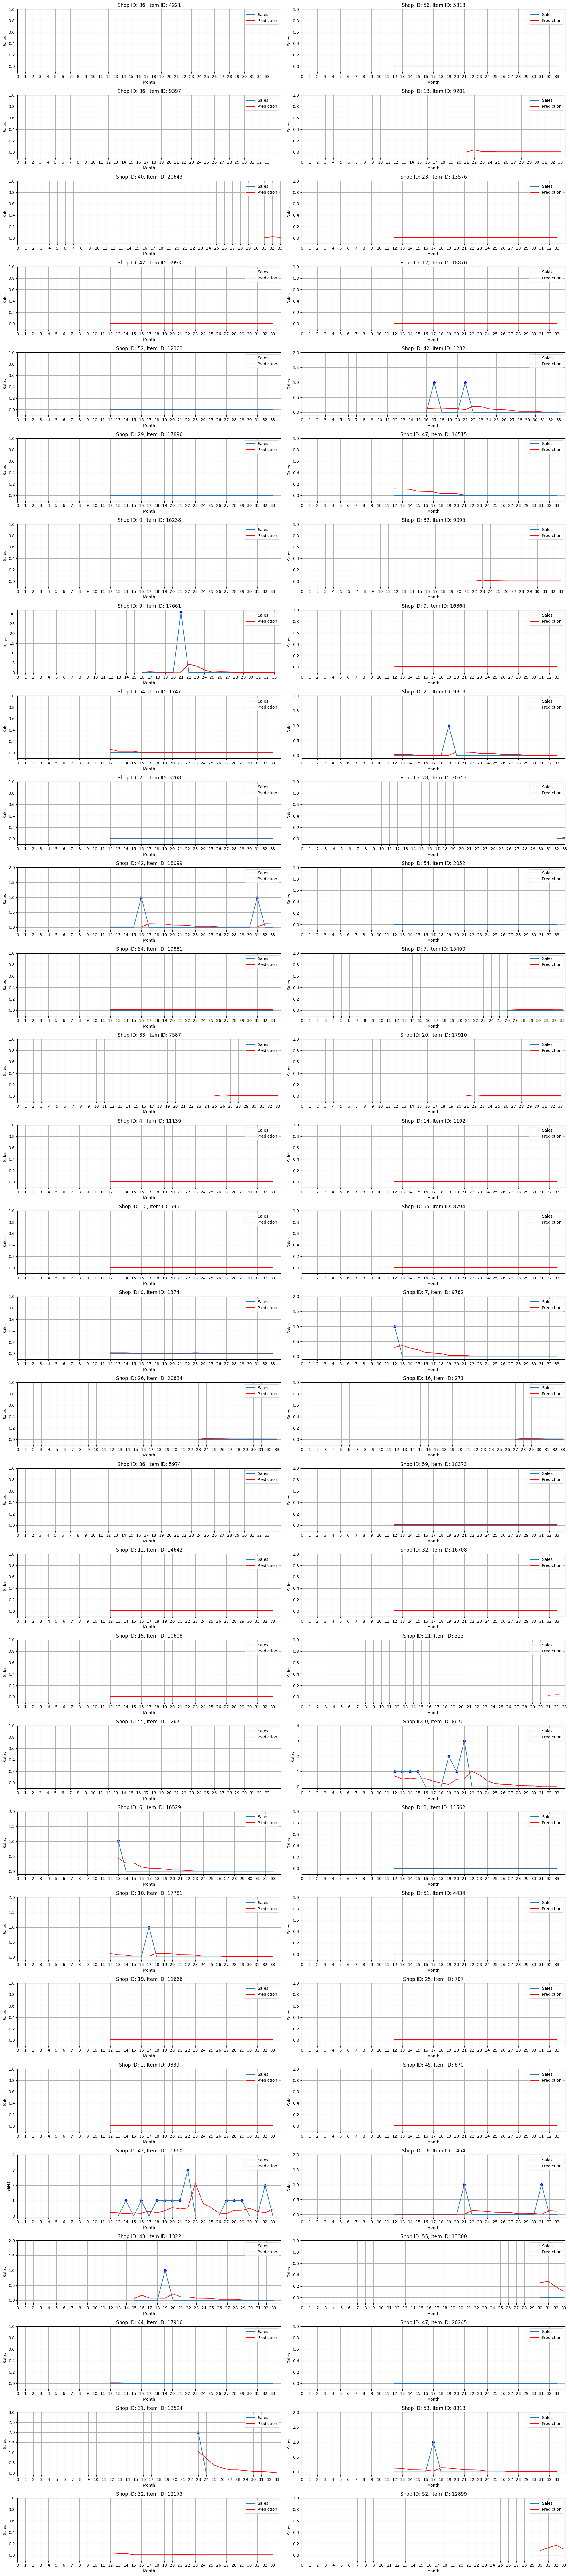

In [33]:
plot_timeseries(train_test_split_pred, plt_rows=30, plt_cols=2, rand=True, pred_col='pred')